# New Narratives for old Buildings

---



Finding narratives through comparison of term frequency across countries

In [1]:
import os, re, csv
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Loading the dataset: heritage homes webistes


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
#path = '/content/gdrive/MyDrive/CDA/' # working with google drive and colab

path = 'datasets/' # working locally

In [4]:
# Country code: change here between 'NL' and 'UK'
cc_list = ['NL', 'UK', 'DE', 'FR']

In [5]:
# Import json data from Aipfy scraping into 4 separate dataframes
df_NL=pd.read_json(path+cc_list[0]+'_dataset_website-content-crawler.json') # NL
# select only two columns for analysis: url and text
df_NL=df_NL[['url','text']]

df_UK=pd.read_json(path+cc_list[1]+'_dataset_website-content-crawler.json') # UK
# select only two columns for analysis: url and text
df_UK=df_UK[['url','text']]

df_DE=pd.read_json(path+cc_list[2]+'_dataset_website-content-crawler.json') # DE
# select only two columns for analysis: url and text
df_DE=df_DE[['url','text']]

df_FR=pd.read_json(path+cc_list[3]+'_dataset_website-content-crawler.json') # FR
# select only two columns for analysis: url and text
df_FR=df_FR[['url','text']]

df_FR.head()

,url,text
0,https://www.chateau-combourg.com/privatisation,Events — COMBOURG\nLe château et le parc peuve...
1,https://www.chateau-combourg.com/chateaubriand,Chateaubriand — COMBOURG\nFrançois-René de Cha...
2,https://www.chateau-combourg.com/prixlitteraire,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...
3,https://www.chateau-combourg.com/contact,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...
4,https://www.suscinio.fr/,Château de Suscinio dans le Morbihan\nOuvert t...


In [6]:
# check if there are further datasets to add per country

!ls "$path" | grep "^UK_"

UK_EH_dataset_website-content-crawler_2025-03-26_09-11-52-434.json
UK_NH_dataset_website-content-crawler_2025-03-26_16-28-44-248.json
UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json
UK_dataset_website-content-crawler.json


In [7]:
# manually append additional datasets (based on previous step)
df_missing1 = pd.read_json(path+'/NL_LG_dataset_website-content-crawler_2025-02-06_09-40-33-880.json')
result = pd.concat([df_NL, df_missing1])

In [8]:
df_missing1 = pd.read_json(path+'/UK_EH_dataset_website-content-crawler_2025-03-26_09-11-52-434.json')
df_missing2 = pd.read_json(path+'/UK_NH_dataset_website-content-crawler_2025-03-26_16-28-44-248.json')
df_missing3 = pd.read_json(path+'/UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json')
result = pd.concat([df_UK, df_missing1, df_missing2, df_missing3])

Join all pages from a domain to an entry in the analysis. To do this, add a new column which will contain only the main domain name.

In [9]:
# function to extract the main domain from the url in the dataset (ALL DOMAINS)
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?:\w+\.)*[\w\-]+\.\w*', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [11]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column

# first, create a mapping of dataframes which could be addressed in a loop
df_dict = {'0':df_NL, '1':df_UK, '2':df_DE, '3':df_FR}

# then, loop through the df_dict to update each dataframe
for k, v in df_dict.items():
  cc_column = cc_list[int(k[-1])]+' domains'
  cc = cc_list[int(k[-1])]
  # print(cc_column, cc)
  urls = pd.read_csv(path+'url_lists/'+cc_list[int(k[-1])]+'_urls.csv')[cc_column].values.tolist()
  domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}
  matching_links = [link for link in v.url if extract_main_domain(link) in domains]
  # update the dataframe
  v['domain'] = v['url'].apply(extract_main_domain)

In [12]:
# check one of the dataframes
df_DE.head()

,url,text,domain
0,http://www.schlossparkmarisfeld.de/,Schlosspark Marisfeld - Schlosspark Marisfeld\...,schlossparkmarisfeld.de
1,http://www.schlossparkmarisfeld.de/information...,Informationen zur Geschichte des Schlossparks\...,schlossparkmarisfeld.de
2,http://www.schlossparkmarisfeld.de/information...,Der Schlosspark Marisfeld - Kleine Parkgeschic...,schlossparkmarisfeld.de
3,http://www.schlossparkmarisfeld.de/information...,Der Förderverein stellt sich vor\nDer aktuelle...,schlossparkmarisfeld.de
4,http://www.schlossparkmarisfeld.de/information...,Die Vereinssatzung - Schlosspark Marisfeld\nFa...,schlossparkmarisfeld.de


## Compare term frequencies across corpora

In [13]:
# list terms to compare
activities = ['kind','spel','avontuur',
              'child','game','adventure',
              'kind', 'spiel', 'abenteuer',
              'enfant', 'jeu', 'aventure']
events = ['feest','bruiloft','bruid','bruidegom',
          'party','wedding','bride','groom',
          'party', 'hochzeit', 'braut', 'bräutigam',
          'fête', 'mariage', 'mariée', 'marié']
nobility = ['graaf','baron','hertog',
            'earl','baron','duke',
            'graf','baron','herzog',
            'compte','baron','duc']
culture = ['tentoonstelling','museum','tuin','park','collectie',
           'exhibition','museum','garden','park','collection',
           'ausstellung','museum','garten','park','sammlung',
           'exposition','musée','jardin','parc','collection']
styles = ['rococo', 'barok', 'renaissance', 'gotiek', # or gotisch
          'rococo', 'baroque', 'renaissance', 'gothic',
          'rokoko', 'barock', 'renaissance', 'gotik',
          'rococo', 'baroque', 'renaissance', 'gothique']

Create texts as 'documents' to count terms and perform tf-idf

In [ ]:
# prototype code to check number of times a term appears in one corpus; use to confirm results of later calculations
term = 'architecture'
corpus = df_UK
term_count = sum([str(item).lower().count(term) for item in corpus['text'].tolist()])
print(int(term_count))

186


In [ ]:
# count term frequencies across four dataframes
list_to_count = events # replace with the name of a list of terms (above)
dataframes = [df_NL, df_UK, df_DE, df_FR] # list of dataframes
number_of_terms = int(len(list_to_count) / 4) # calculate the number of terms in 1 language

term_count_dict = {}
start, end = 0, number_of_terms
for i, df in enumerate(dataframes):
  term_count_values = []
  for term in list_to_count[start:end]:
    #print(term)
    term_count_column = sum([str(item).lower().count(term) for item in df['text'].tolist()])
    #print(int(term_count_column.sum()))
    term_count_values.append(int(term_count_column))
  start += number_of_terms
  end += number_of_terms
  term_count_dict[cc_list[i]] = term_count_values

term_count_dict

{'NL': [1401, 273, 335, 5],
 'UK': [701, 1944, 106, 57],
 'DE': [268, 592, 66, 3],
 'FR': [1040, 694, 21, 71]}

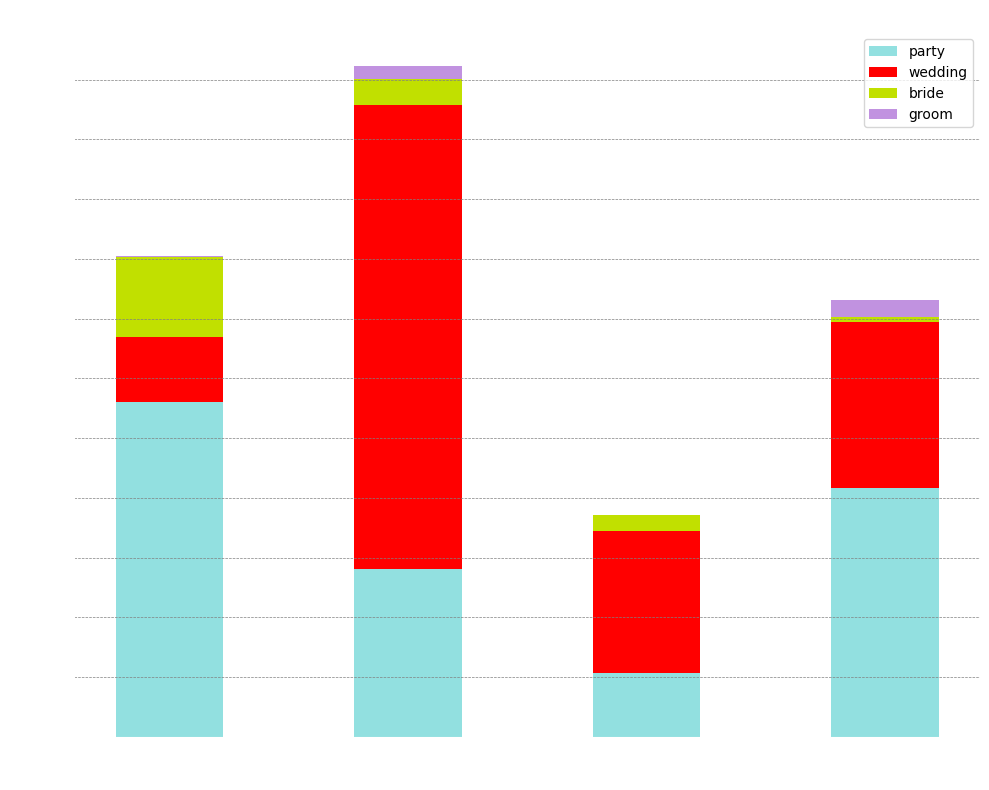

In [ ]:
# Visualize the term count as a stacked bar chart per country
theme = 'parties'
terms = list_to_count[number_of_terms:number_of_terms*2] # change which section of the list is used in the legend
# Create a list of countries (y-axis labels)
countries = list(term_count_dict.keys())

# Create the stacked bar chart
width = 0.45  # Width of the bars

fig, ax = plt.subplots(figsize=(10,8))

bottom = np.zeros(len(countries))
colors = ['#92E0E0', 'red', '#C1E000', '#C192E0','#E05543','#E0C200']

# Add horizontal lines for values in the legend
for value in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750]:
    #[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    #[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750]
    #[100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    #[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    #[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000] # activities
    #[2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500] # arts & culture
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)

for term_index in range(len(terms)):
    term_counts = [term_count_dict[country][term_index] for country in countries]
    ax.bar(countries, term_counts, width, label=terms[term_index], bottom=bottom,
           color=colors[term_index % len(colors)])
    bottom += np.array(term_counts)

ax.set_xlabel('Countries', color='white')
ax.set_ylabel('Term Counts', color='white')
ax.set_title('Terms related to '+theme+' per country', color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend()

plt.tight_layout()
plt.savefig(path+'outputs/2024_'+theme+'.png', transparent=True)
plt.show()

In [ ]:
# count term frequencies across four dataframes
terms = ['architectuur', 'architecture', 'architektur', 'architecture'] # replace with the name of a list of terms (above)
dataframes = [df_NL, df_UK, df_DE, df_FR] # list of dataframes

term_count_dict = {}
for i, df in enumerate(dataframes):
  term_count_values = []
  #print(terms[i])
  term_count_column = sum([str(item).lower().count(terms[i]) for item in df['text'].tolist()])
  #print(int(term_count_column.sum()))
  term_count_values.append(int(term_count_column))
  term_count_dict[cc_list[i]] = term_count_values

term_count_dict

{'NL': [128], 'UK': [186], 'DE': [556], 'FR': [3889]}

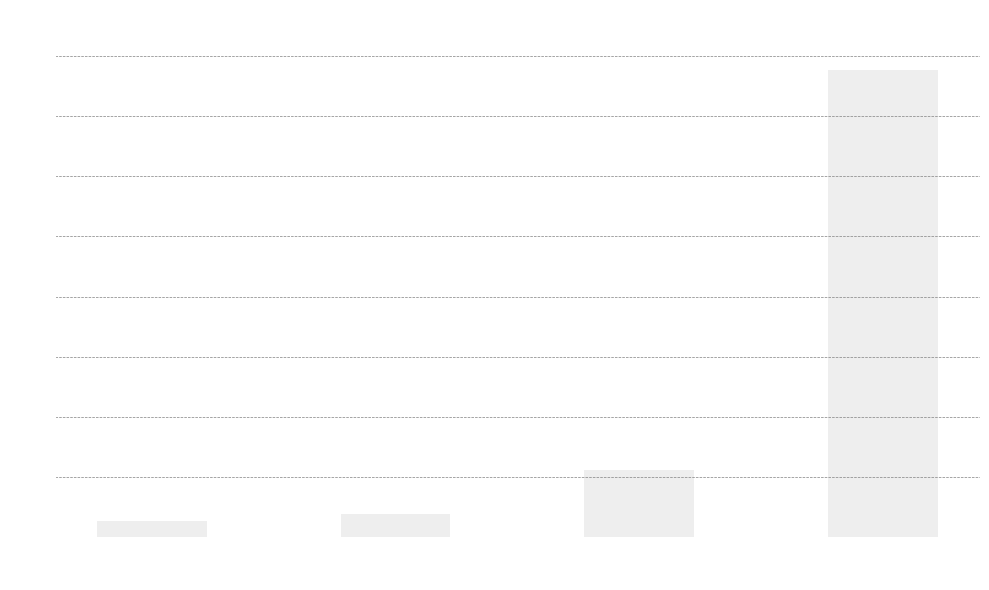

In [ ]:
theme = terms[1]
# Visualize the term count as a vertical bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.45  # Width of the bars
# Get the keys and values from the dictionary
countries = list(term_count_dict.keys())
counts = list(term_count_dict.values())

# Flatten the counts list if it contains nested lists
if isinstance(counts[0], list):
  counts = [item for sublist in counts for item in sublist]

# Add horizontal lines for values in the legend
for value in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]:

  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
# Create the bar chart
ax.bar(countries, counts, width, color='#eee')

# Set the labels and title
ax.set_xlabel('Terms', color='white')
ax.set_title('Frequency of term \"'+theme+'\" per country', color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# Rotate x-axis labels if needed
plt.xticks(rotation=0, ha='right', color='white')


# Display the chart
plt.tight_layout()
plt.savefig(path+'outputs/2024_'+theme+'.png', transparent=True)
plt.show()


## Compare TF-IDF across corpora

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initiate separate corpora and compute step by step to not overflow the RAM
corpus_NL = df_NL['text'].dropna().tolist()
corpus_UK = df_UK['text'].dropna().tolist()
corpus_DE = df_DE['text'].dropna().tolist()
corpus_FR = df_FR['text'].dropna().tolist()

In [15]:
print(len(corpus_UK))

6942


In [17]:
# Calculate tf-idf scores for NL corpus

vectorizer_NL = TfidfVectorizer()
tfidf_matrix_NL = vectorizer_NL.fit_transform(corpus_NL)
feature_names_NL = vectorizer_NL.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_NL = tfidf_matrix_NL.toarray()

# Save the tfidf matrices and feature names
'''
with open(path + 'outputs/tfidf_scores_NL.pickle', 'wb') as handle:
    pickle.dump(tfidf_scores_NL, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + 'outputs/feature_names_NL.pickle', 'wb') as handle:
    pickle.dump(feature_names_NL, handle, protocol=pickle.HIGHEST_PROTOCOL)
    '''

"\nwith open(path + 'outputs/tfidf_scores_NL.pickle', 'wb') as handle:\n    pickle.dump(tfidf_scores_NL, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open(path + 'outputs/feature_names_NL.pickle', 'wb') as handle:\n    pickle.dump(feature_names_NL, handle, protocol=pickle.HIGHEST_PROTOCOL)\n    "

In [ ]:
# load saved models, to avoid using up all RAM
with open(path + 'outputs/tfidf_scores_NL.pickle', 'rb') as handle:
    tfidf_scores_NL = pickle.load(handle)
with open(path + 'outputs/feature_names_NL.pickle', 'rb') as handle:
    feature_names_NL = pickle.load(handle)

In [18]:
# Calculate tf-idf scores for UK corpus

vectorizer_UK = TfidfVectorizer()
tfidf_matrix_UK = vectorizer_UK.fit_transform(corpus_UK)
feature_names_UK = vectorizer_UK.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_UK = tfidf_matrix_UK.toarray()
'''
with open(path + 'outputs/tfidf_scores_UK.pickle', 'wb') as handle:
    pickle.dump(tfidf_scores_UK, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + 'outputs/feature_names_UK.pickle', 'wb') as handle:
    pickle.dump(feature_names_UK, handle, protocol=pickle.HIGHEST_PROTOCOL)'''

"\nwith open(path + 'outputs/tfidf_scores_UK.pickle', 'wb') as handle:\n    pickle.dump(tfidf_scores_UK, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open(path + 'outputs/feature_names_UK.pickle', 'wb') as handle:\n    pickle.dump(feature_names_UK, handle, protocol=pickle.HIGHEST_PROTOCOL)"

In [ ]:
# load saved models, to avoid using up all RAM
with open(path + 'outputs/tfidf_scores_UK.pickle', 'rb') as handle:
    tfidf_scores_UK = pickle.load(handle)
with open(path + 'outputs/feature_names_UK.pickle', 'rb') as handle:
    feature_names_UK = pickle.load(handle)

In [19]:
# Calculate tf-idf scores for DE corpus

vectorizer_DE = TfidfVectorizer()
tfidf_matrix_DE = vectorizer_DE.fit_transform(corpus_DE)
feature_names_DE = vectorizer_DE.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_DE = tfidf_matrix_DE.toarray()

'''
with open(path + 'outputs/tfidf_scores_DE.pickle', 'wb') as handle:
    pickle.dump(tfidf_scores_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + 'outputs/feature_names_DE.pickle', 'wb') as handle:
    pickle.dump(feature_names_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)'''

"\nwith open(path + 'outputs/tfidf_scores_DE.pickle', 'wb') as handle:\n    pickle.dump(tfidf_scores_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open(path + 'outputs/feature_names_DE.pickle', 'wb') as handle:\n    pickle.dump(feature_names_DE, handle, protocol=pickle.HIGHEST_PROTOCOL)"

In [ ]:
# load saved models, to avoid using up all RAM
with open(path + 'outputs/tfidf_scores_DE.pickle', 'rb') as handle:
    tfidf_scores_DE = pickle.load(handle)
with open(path + 'outputs/feature_names_DE.pickle', 'rb') as handle:
    feature_names_DE = pickle.load(handle)

In [20]:
# Calculate tf-idf scores for FR corpus

vectorizer_FR = TfidfVectorizer()
tfidf_matrix_FR = vectorizer_FR.fit_transform(corpus_FR)
feature_names_FR = vectorizer_FR.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_FR = tfidf_matrix_FR.toarray()
'''
with open(path + 'outputs/tfidf_scores_FR.pickle', 'wb') as handle:
    pickle.dump(tfidf_scores_FR, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + 'outputs/feature_names_FR.pickle', 'wb') as handle:
    pickle.dump(feature_names_FR, handle, protocol=pickle.HIGHEST_PROTOCOL)'''

"\nwith open(path + 'outputs/tfidf_scores_FR.pickle', 'wb') as handle:\n    pickle.dump(tfidf_scores_FR, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open(path + 'outputs/feature_names_FR.pickle', 'wb') as handle:\n    pickle.dump(feature_names_FR, handle, protocol=pickle.HIGHEST_PROTOCOL)"

In [ ]:
with open(path + 'outputs/tfidf_scores_FR.pickle', 'wb') as handle:
    pickle.dump(tfidf_scores_FR, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + 'outputs/feature_names_FR.pickle', 'wb') as handle:
    pickle.dump(feature_names_FR, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
feature_names_UK

array(['00', '000', '0000', ..., 'ﬁnest', 'ﬁrst', 'ﬂowers'], dtype=object)

In [54]:
list_to_count = nobility # replace with the name of a list of terms activities / events / nobility / culture / styles
feature_names = [feature_names_NL, feature_names_UK, feature_names_DE, feature_names_FR] # list of dataframes
tfidf_scores = [tfidf_scores_NL, tfidf_scores_UK, tfidf_scores_DE, tfidf_scores_FR]
number_of_terms = int(len(list_to_count) / 4) # calculate the number of terms in 1 language

term_count_dict = {}
start, end = 0, number_of_terms
for i, fn in enumerate(feature_names):
  term_count_values = []
  for term in list_to_count[start:end]:
    #print(term)
    if term in fn:
      #print(term)
      term_index = list(fn).index(term)
      # Calculate the aggregated TF-IDF score for the term 'park'
      total_tfidf_score = tfidf_scores[i][:, term_index].sum()
      average_tfidf_score = tfidf_scores[i][:, term_index].mean()
    #print(int(term_count_column.sum()))
    term_count_values.append(float(average_tfidf_score))
  start += number_of_terms
  end += number_of_terms
  term_count_dict[cc_list[i]] = term_count_values

term_count_dict

{'NL': [0.0007154356731806572, 0.0019353448291872407, 0.00040440569201608147],
 'UK': [0.0011734103780235382, 0.0005330887264544085, 0.0012592211744192356],
 'DE': [0.0011460390914352476, 0.00011979592398027848, 0.0010664374280878847],
 'FR': [0.0011410641233413376, 0.0001949087993802904, 0.0027267206633930477]}

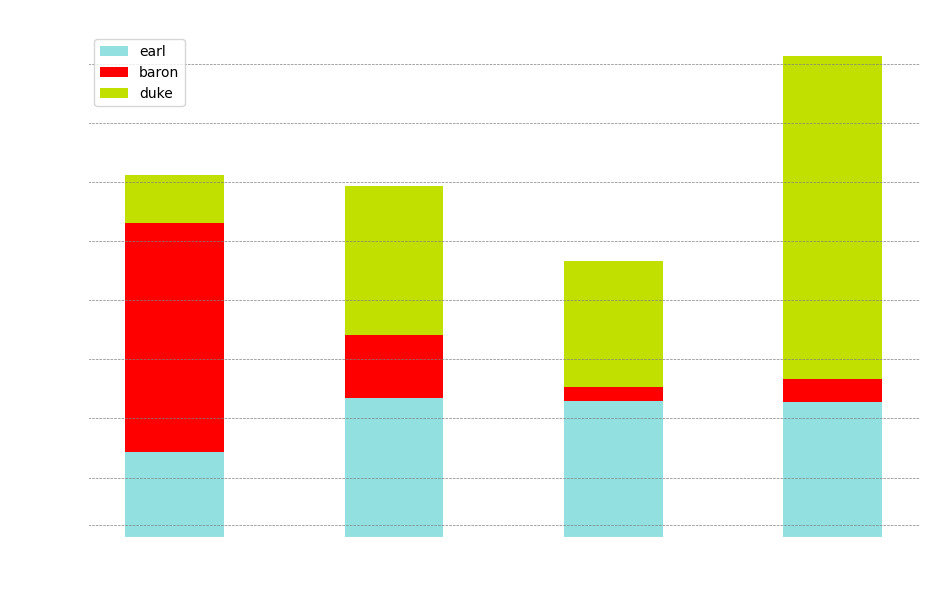

In [57]:
# Visualize the term count as a stacked bar chart per country
theme = list_to_count[number_of_terms+1]
terms = list_to_count[number_of_terms:number_of_terms*2] # change which section of the list is used in the legend
# Create a list of countries (y-axis labels)
countries = list(term_count_dict.keys())

# Create the stacked bar chart
width = 0.45  # Width of the bars

fig, ax = plt.subplots(figsize=(9.4,6))

bottom = np.zeros(len(countries))
colors = ['#92E0E0', 'red', '#C1E000', '#C192E0','#E05543','#E0C200']

# Add horizontal lines for values in the legend
for value in [0.0001, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]:
    #[0.0001, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035] # nobility
    #[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014] # activities
    #[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045] # culture
    #[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # events + styles
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)

for term_index in range(len(terms)):
    term_counts = [term_count_dict[country][term_index] for country in countries]
    ax.bar(countries, term_counts, width, label=terms[term_index], bottom=bottom,
           color=colors[term_index % len(colors)])
    bottom += np.array(term_counts)

ax.set_xlabel('Countries', color='white')
ax.set_ylabel('Term Counts', color='white')
ax.set_title('Terms related to '+theme+' per country', color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend()

plt.tight_layout()
plt.savefig(path+'outputs/2024_tfidf_'+theme+'.png', transparent=True)
plt.show()
